In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
import time


In [2]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

from PIL import Image

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [3]:
random.seed(1008)
random.shuffle(unlabeled_scene_index)
train_scene = unlabeled_scene_index[:85]
val_scene = unlabeled_scene_index[85:]

transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, 
                                      scene_index=train_scene, 
                                      first_dim='image', transform=transform)
unlabeled_valset = UnlabeledDataset(image_folder = image_folder, 
                                    scene_index = val_scene, 
                                    first_dim = 'image', transform = transform)

train_loader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=1, 
                                           shuffle = True, num_workers=2)
val_loader = torch.utils.data.DataLoader(unlabeled_valset, batch_size=1, 
                                         shuffle = True, num_workers=2)


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        feature_extractor = torchvision.models.resnet50(pretrained=False)
        feature_extractor = list(feature_extractor.children())[:-3]
        
        generator_list = feature_extractor + [nn.Conv2d(1024, 4000, 4, bias = False),
            nn.BatchNorm2d(4000),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(4000,512, 4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  
            nn.Upsample((128, 153), mode='bilinear', align_corners=False),
            nn.Tanh(),]
        
        self.main = nn.Sequential(*generator_list)
        
    def forward(self, input):
        output = self.main(input)
        return output
 

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias= False), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(64, 64 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        return output

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
from torch.autograd import Variable

In [9]:
BATCH_SIZE=1
mini_set, _ = torch.utils.data.random_split(unlabeled_trainset, [5, len(unlabeled_trainset) - 5])
mini_val, _ = torch.utils.data.random_split(unlabeled_valset, [3, len(unlabeled_valset)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          )

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          )

In [ ]:
unlabeled_trainset[419][0].shape

In [ ]:
real_center.shape

In [ ]:
real_center = real_center.cuda()

In [ ]:
discriminator = Discriminator().cuda()
output = discriminator(real_center)

In [ ]:
labels = torch.FloatTensor(1).to(device)

In [ ]:
output.shape

In [ ]:
output = output.squeeze(0).squeeze(0).squeeze(0)

In [ ]:
output.shape

In [ ]:
output

In [ ]:
criterion1(output, labels)

In [ ]:
fake = netG(input_cropped)

In [ ]:
fake.shape

In [ ]:
real_center.shape

In [ ]:
criterion2(fake, real_center)

In [ ]:
label.data.fill_(real_label)
output = discriminator(real_center)
errD_real = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
D_x = output.mean().item()

In [ ]:
errD_real


In [ ]:
fake = generator(input_cropped)
label.data.fill_(fake_label)
output = discriminator(fake.detach())
errD_fake = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
D_G_z1 = output.mean().item()

In [ ]:
errD_fake

In [ ]:
errD = errD_real + errD_fake


In [ ]:
errD

In [ ]:
label.data.fill_(real_label)
            
output = discriminator(fake.detach())

errG_D = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)

errG_l2 = criterion2(fake, real_center)

errG = 0.05*errG_D + 0.95*errG_l2

In [ ]:
errG

In [ ]:
errG_l2

In [10]:
def train_GAN_model(generator, discriminator, train_loader, val_loader, 
                    optG, optD, criterion1, criterion2, num_epochs, checkpoint, to_save, eval_every):
    if checkpoint:
        pt = torch.load(checkpoint)
        generator.load_state_dict(pt['netG'])
        discriminator.load_state_dict(pt['netD'])
        optG.load_state_dict(pt['optG'])
        optD.load_state_dict(pt['optD'])
        best_loss  =pt['best_loss']
    else:
        best_loss = 1e10
    G_losses = []
    D_losses = []
    eval_losses = []
    
    # Create the container     
    input_real = torch.FloatTensor(1, 3, 256, 306).to(device)
    input_cropped = torch.FloatTensor(1, 3, 256, 306).to(device)
    real_center = torch.FloatTensor(1, 3, 128, 153).to(device)
    label = torch.FloatTensor(1).to(device)
    
    input_real = Variable(input_real)
    input_cropped = Variable(input_cropped)
    label = Variable(label)
    real_center = Variable(real_center)

    for epoch in range(num_epochs):
        for i, (image, _) in enumerate(train_loader):
            real_center_cpu = image[:, :, 64:192, 76:229]
            input_real.data.copy_(image)
            input_cropped.data.copy_(image)

            real_center.data.copy_(real_center_cpu)
            input_cropped.data[:, 0, 64:192, 76:229] = 2*117.0/255.0 - 1.0
            input_cropped.data[:, 1, 64:192, 76:229] = 2*104.0/255.0 - 1.0
            input_cropped.data[:, 2, 64:192, 76:229] = 2*123.0/255.0 - 1.0

            # Train with real data
            discriminator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(real_center)
            errD_real = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
            errD_real.backward()
            D_x = output.mean().item()

            # Train with false data
            fake = generator(input_cropped)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_fake = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            
            errD = errD_real + errD_fake
            optD.step()


            # Train generator
            generator.zero_grad()
            
            label.data.fill_(real_label)
            
            output = discriminator(fake.detach())
            
            errG_D = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)

            errG_l2 = criterion2(fake, real_center)
            
            errG = 0.05*errG_D + 0.95*errG_l2
        
            #errG = errG_l2
            errG.backward()
            optG.step()
            
            if i% eval_every ==0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f / %.4f l_D(x): %.4f l_D(G(z)): %.4f'
              % (epoch, num_epochs, i, len(train_loader),
                 errD.item(), errG_D.item(),errG_l2.item(), D_x,D_G_z1, ))
                
                for i, (image, _) in enumerate(val_loader):
                    eval_loss = 0.0
                    generator.eval()
                    discriminator.eval()
                    real_center_cpu = image[:, :, 64:192, 76:229]
                    input_real.data.copy_(image)
                    input_cropped.data.copy_(image)

                    real_center.data.copy_(real_center_cpu)
                    input_cropped.data[:, 0, 64:192, 76:229] = 2*117.0/255.0 - 1.0
                    input_cropped.data[:, 1, 64:192, 76:229] = 2*104.0/255.0 - 1.0
                    input_cropped.data[:, 2, 64:192, 76:229] = 2*123.0/255.0 - 1.0

                    with torch.no_grad():
                        # eval with real:
                        label.data.fill_(real_label)
                        output = discriminator(real_center)
                        errD_real = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
                        
                        fake = generator(input_cropped)
                        output = discriminator(fake.detach())
                        label.data.fill_(fake_label)
                        errD_fake = criterion1(output.squeeze(0).squeeze(0).squeeze(0), label)
                        
                        errD = errD_real + errD_fake
                        
                        #label.data.fill_(real_label)
                        errG = criterion2(fake, real_center)
                        
                        eval_loss += 0.01*errD.item() + 0.99*errG.item()

                eval_loss/=len(val_loader)
                eval_losses.append(eval_loss)
                print('current evaluation loss: ', eval_loss)

                if eval_loss < best_loss:
                    print('saving best_model')
                    best_loss  =eval_loss
                    checkpoint = {'netG': generator.state_dict(), 
                                  'netD': discriminator.state_dict(), 
                                  'optG': optG.state_dict(), 
                                  'optD': optD.state_dict(), 
                                  'best_loss': best_loss}
                    torch.save(checkpoint, to_save)
            
#             ## make a test print
#             j = random.randrange(len(train_loader))
#             image = unlabeled_trainset[j][0].unsqueeze(0)
            
#             input_cropped.data.copy_(image)
            
#             real_center_cpu = image[:, :, 64:192, 76:229]
#             real_center.data.copy_(real_center_cpu)
            
#             input_cropped.data[:, 0, 64:192, 76:229] = 2*117.0/255.0 - 1.0
#             input_cropped.data[:, 1, 64:192, 76:229] = 2*104.0/255.0 - 1.0
#             input_cropped.data[:, 2, 64:192, 76:229] = 2*123.0/255.0 - 1.0
            
#             predictions = generator(input_cropped)
#             result = torch.FloatTensor(1, 3, 256, 306)
#             result.data.copy_(input_cropped)
#             result.data[:, 0, 64:192, 76:229] = predictions.detach()[:, 0, :, :]
#             result.data[:, 1, 64:192, 76:229] = predictions.detach()[:, 1, :, :]
#             result.data[:, 2, 64:192, 76:229] = predictions.detach()[:, 2, :, :]
#             plt.imshow(result[0].cpu().numpy().transpose(1,2,0))
#             plt.show()
            
#             # end of test print
            generator.train()
            discriminator.train()
            G_losses.append(errG.item()/len(train_loader))
            D_losses.append(errD.item()/len(train_loader))
    
    fig = plt.figure()
    plt.plot(G_losses)
    plt.title('Glosses')
    plt.show()
    
    fig = plt.figure()
    plt.plot(D_losses)
    plt.title('D_losses')
    plt.show()
    
    fig = plt.figure()
    plt.plot(eval_losses)
    plt.title('Evaluation Loss')
    plt.show()
    
    return generator, discriminator, G_losses, D_losses, eval_losses
            

[0/3][0/64260] Loss_D: 2.3547 Loss_G: 8.8009 / 0.1839 l_D(x): 0.2224 l_D(G(z)): 0.5732
current evaluation loss:  3.274881902075018e-05
saving best_model
[0/3][10000/64260] Loss_D: 0.0000 Loss_G: 22.0037 / 0.0326 l_D(x): 1.0000 l_D(G(z)): 0.0000
current evaluation loss:  3.6782373548207283e-06
saving best_model
[0/3][20000/64260] Loss_D: 0.0001 Loss_G: 17.9156 / 0.0167 l_D(x): 0.9999 l_D(G(z)): 0.0000
current evaluation loss:  2.1400596452776024e-06
saving best_model
[0/3][30000/64260] Loss_D: 0.0000 Loss_G: 17.8669 / 0.0187 l_D(x): 1.0000 l_D(G(z)): 0.0000
current evaluation loss:  8.86534381743251e-06
[0/3][40000/64260] Loss_D: 0.0000 Loss_G: 22.7942 / 0.0417 l_D(x): 1.0000 l_D(G(z)): 0.0000
current evaluation loss:  1.835439346672516e-06
saving best_model
[0/3][50000/64260] Loss_D: 0.0000 Loss_G: 16.9380 / 0.0326 l_D(x): 1.0000 l_D(G(z)): 0.0000
current evaluation loss:  2.710157285130478e-06
[0/3][60000/64260] Loss_D: 0.0000 Loss_G: 15.6212 / 0.0349 l_D(x): 1.0000 l_D(G(z)): 0.0000


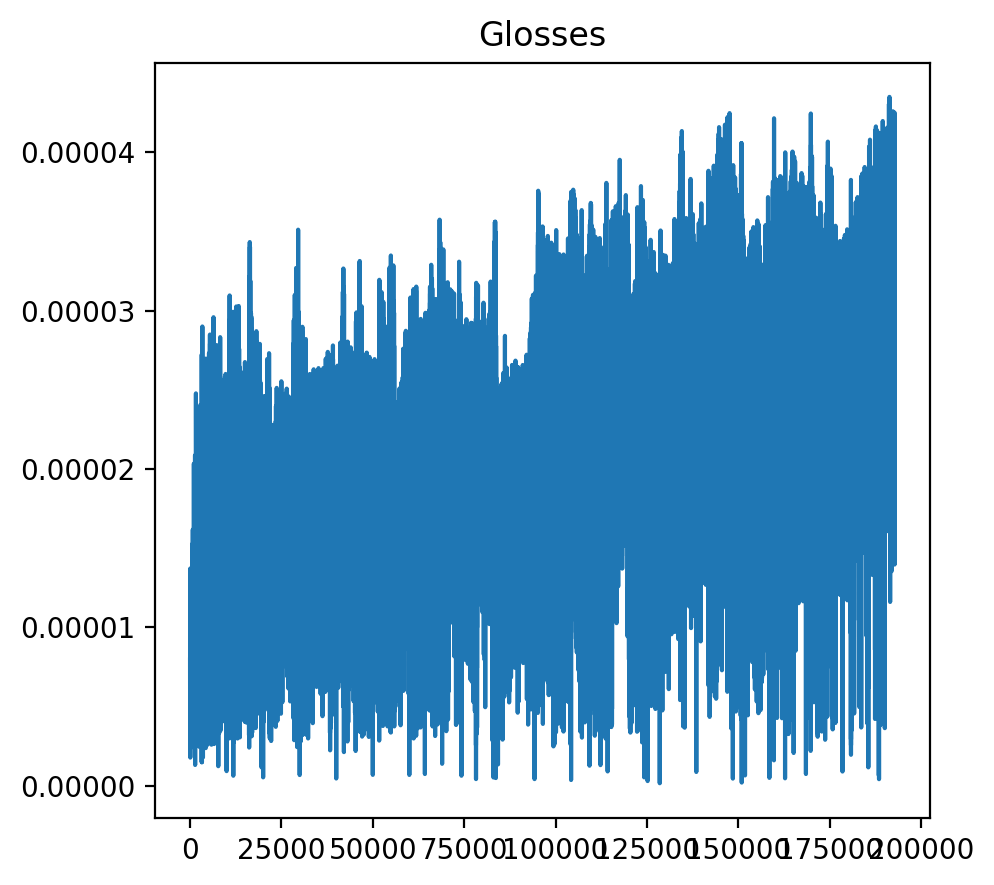

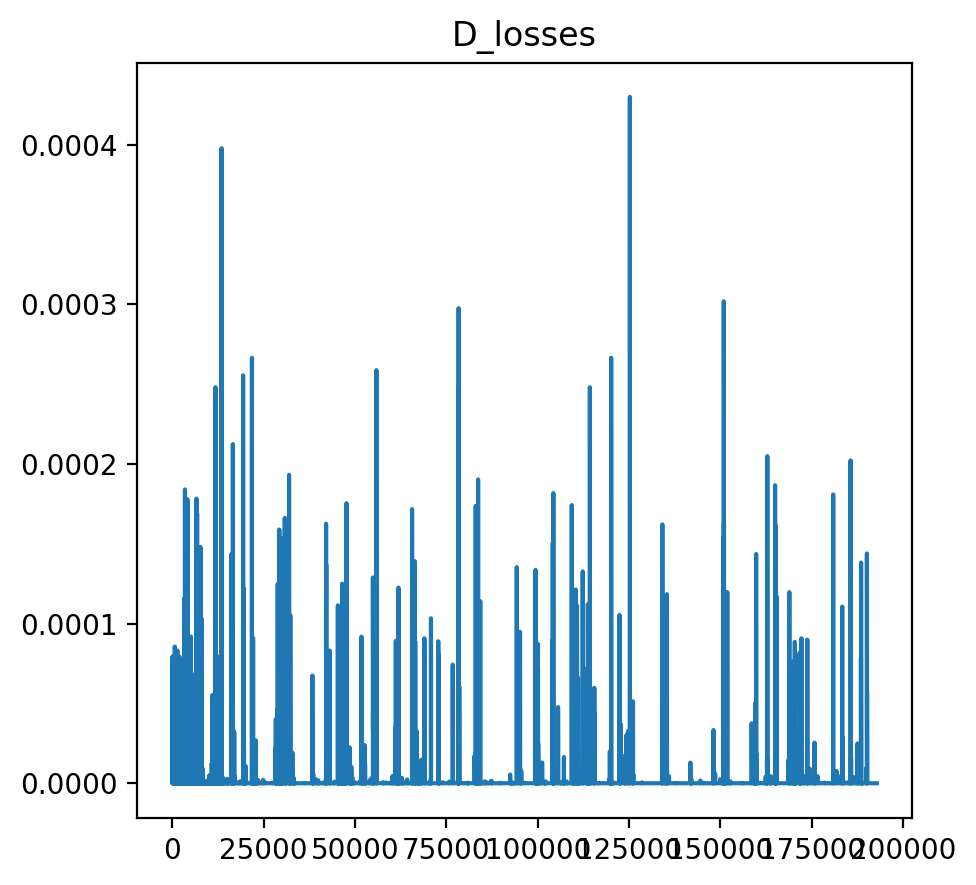

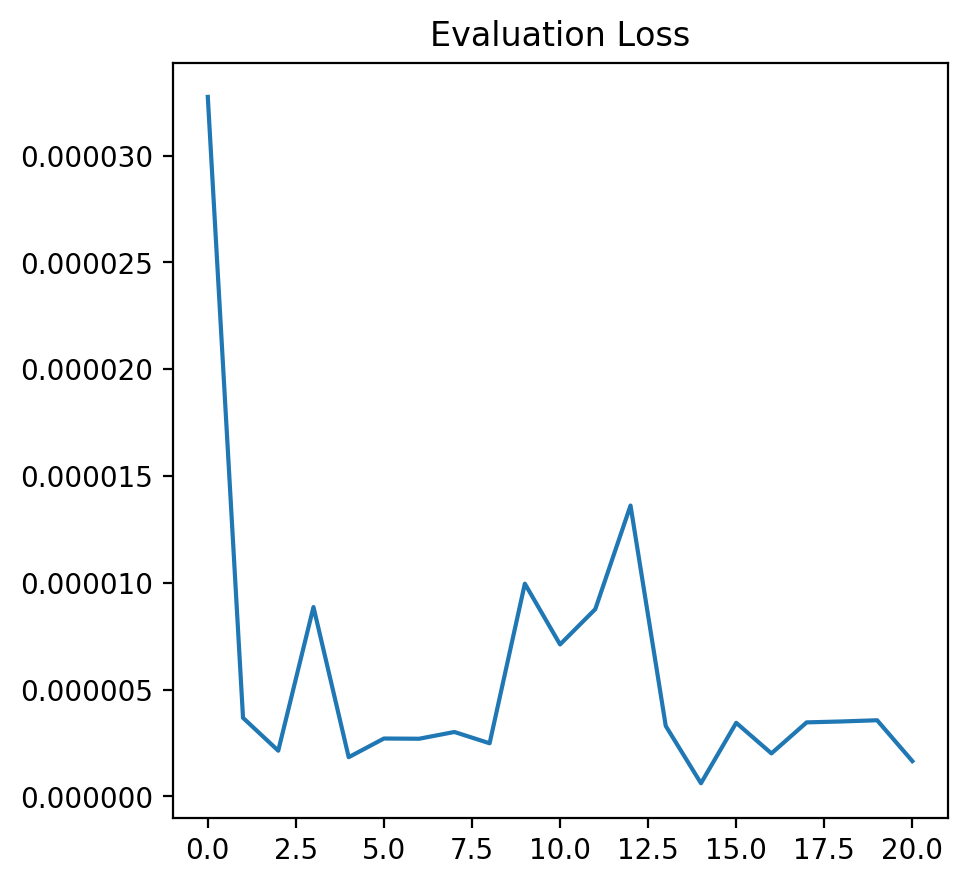

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

real_label = 1
fake_label=0

criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

optG = torch.optim.Adam(generator.parameters(), lr=1e-3, betas= (0.9, 0.999))
optD = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas= (0.9, 0.999))

generator, discriminator, G_losses, D_losses, eval_losses = train_GAN_model(generator, discriminator, train_loader, 
                                                                            val_loader, 
                optG, optD, criterion1, criterion2, num_epochs=3, checkpoint=None, 
                to_save='/scratch/ht1162/DLResult/pre_task_inpainting.pth', eval_every=10000)

In [13]:
GAN_checkpoint = torch.load('/scratch/ht1162/DLResult/pre_task_inpainting.pth')


In [14]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [15]:
netG = netG.load_state_dict(GAN_checkpoint['netG'])
netD  =netD.load_state_dict(GAN_checkpoint['netD'])

In [17]:
input_real = torch.FloatTensor(1, 3, 256, 306).to(device)
input_cropped = torch.FloatTensor(1, 3, 256, 306).to(device)
real_center = torch.FloatTensor(1, 3, 128, 153).to(device)

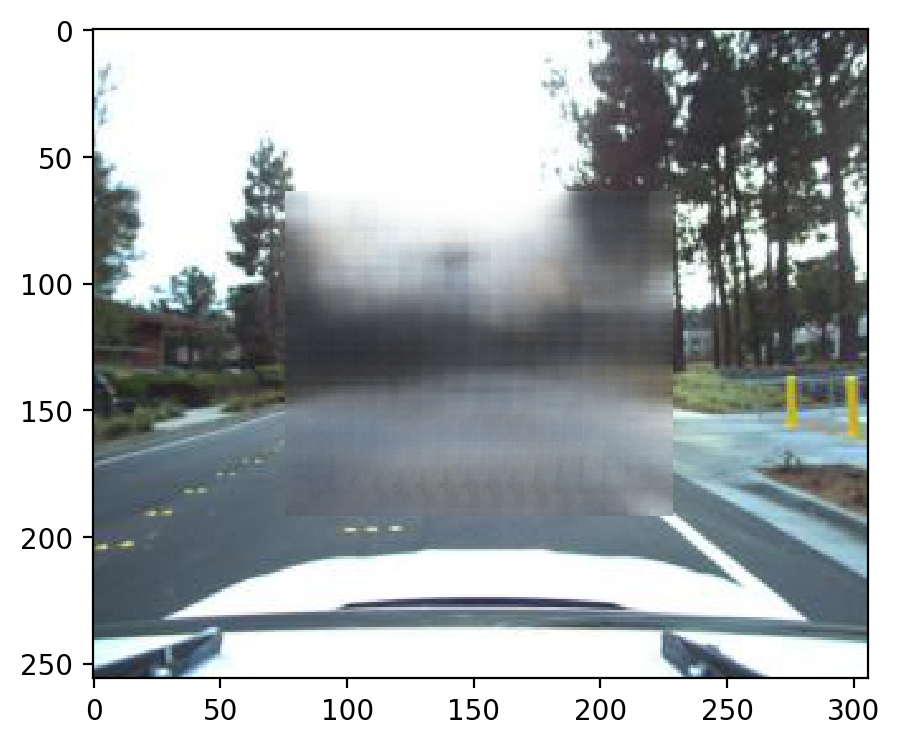

In [23]:
j = random.randrange(len(train_loader))
image = unlabeled_trainset[j][0].unsqueeze(0)

input_cropped.data.copy_(image)

real_center_cpu = image[:, :, 64:192, 76:229]
real_center.data.copy_(real_center_cpu)

input_cropped.data[:, 0, 64:192, 76:229] = 2*117.0/255.0 - 1.0
input_cropped.data[:, 1, 64:192, 76:229] = 2*104.0/255.0 - 1.0
input_cropped.data[:, 2, 64:192, 76:229] = 2*123.0/255.0 - 1.0

predictions = generator(input_cropped)
result = torch.FloatTensor(1, 3, 256, 306)
result.data.copy_(input_cropped)
result.data[:, 0, 64:192, 76:229] = predictions.detach()[:, 0, :, :]
result.data[:, 1, 64:192, 76:229] = predictions.detach()[:, 1, :, :]
result.data[:, 2, 64:192, 76:229] = predictions.detach()[:, 2, :, :]
plt.imshow(result[0].cpu().numpy().transpose(1,2,0))
plt.savefig('/scratch/ht1162/DLResult/inpainting_gan_sample3.png')
plt.show()

In [28]:
j

[55306, 36293, 56741, 9406, 993, 25087]

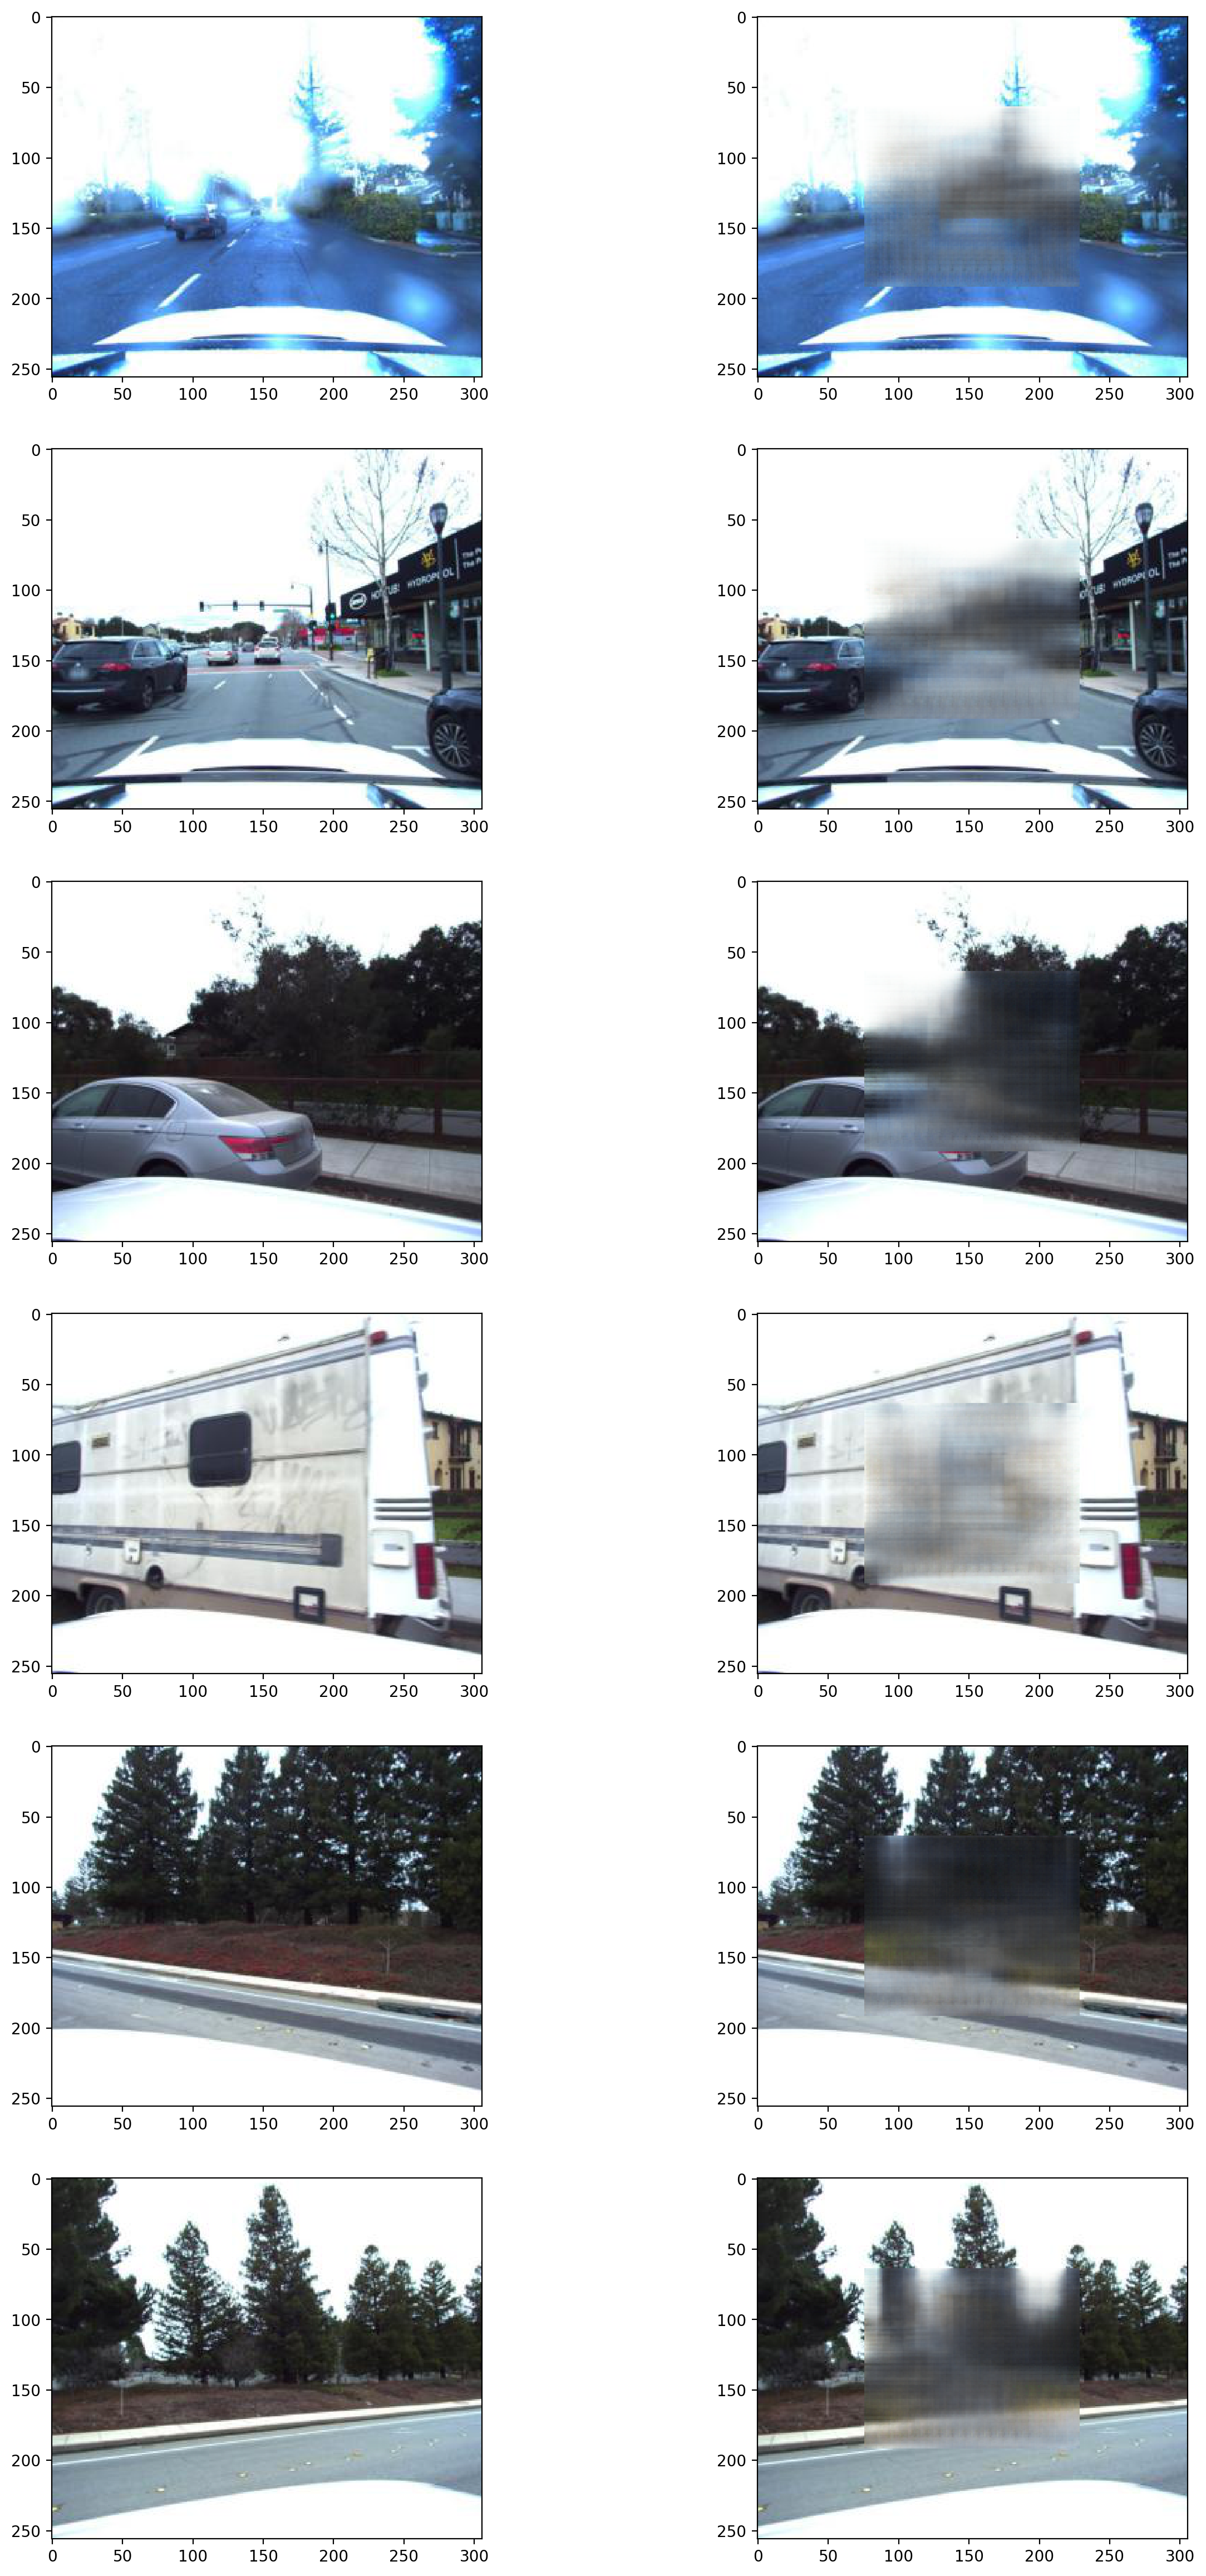

In [36]:
fig, ax = plt.subplots(6, 2, figsize=(15,30))
j = random.sample(range(len(val_loader)),6)

for fig_i, i in enumerate(j):
    image = unlabeled_valset[i][0].unsqueeze(0)

    input_cropped.data.copy_(image)

    real_center_cpu = image[:, :, 64:192, 76:229]
    real_center.data.copy_(real_center_cpu)

    input_cropped.data[:, 0, 64:192, 76:229] = 2*117.0/255.0 - 1.0
    input_cropped.data[:, 1, 64:192, 76:229] = 2*104.0/255.0 - 1.0
    input_cropped.data[:, 2, 64:192, 76:229] = 2*123.0/255.0 - 1.0
    with torch.no_grad():
        predictions = generator(input_cropped)
    result = torch.FloatTensor(1, 3, 256, 306)
    result.data.copy_(input_cropped)
    result.data[:, 0, 64:192, 76:229] = predictions.detach()[:, 0, :, :]
    result.data[:, 1, 64:192, 76:229] = predictions.detach()[:, 1, :, :]
    result.data[:, 2, 64:192, 76:229] = predictions.detach()[:, 2, :, :]
    ax[fig_i, 0].imshow(image[0].cpu().numpy().transpose(1,2,0))

    ax[fig_i, 1].imshow(result[0].cpu().numpy().transpose(1,2,0))
plt.savefig('/scratch/ht1162/DLResult/inpainting_gan_sample_val2.png')
plt.show()

In [12]:
generator, discriminator, G_losses, D_losses, eval_losses = train_GAN_model(generator, discriminator, train_loader, 
                                                                            val_loader, 
                optG, optD, criterion1, criterion2, num_epochs=5, checkpoint='/scratch/ht1162/DLResult/pre_task_inpainting.pth', 
                to_save='/scratch/ht1162/DLResult/pre_task_inpainting.pth', eval_every=10000)

[0/5][0/64260] Loss_D: 0.0000 Loss_G: 23.8881 / 0.0475 l_D(x): 1.0000 l_D(G(z)): 0.0000


KeyboardInterrupt: 